### Deep learning model training.


In [1]:
import os
import re
import torch
import glob
import time
import random
import torch.nn as nn
from torchsummary import summary
from model.model.unet import unet
from utils.dataloader import Dataset
from utils.imgShow import imsShow
from utils.acc_metric import oa_binary, miou_binary


### dataset loading

In [2]:
# ----------Data paths-------------- 
pattern = re.compile(r'[a-z]\d_scene_(\d+)')
all_truth_paths = sorted(glob.glob('data/truth/*.tif'))

paths_truth_tra = []
paths_truth_val = []

paths_dem_tra = []
paths_dem_val = []

for path in all_truth_paths:
    filename = os.path.basename(path) 
    
    match = pattern.search(filename) 
    
    if match:
        scene_number_str = match.group(1) 
        scene_number = int(scene_number_str) 
        if scene_number >= 11:
            paths_truth_val.append(path)
        else:
            paths_truth_tra.append(path)

paths_scene_tra = [p.replace('truth', 'scene') for p in paths_truth_tra]
paths_scene_val = [p.replace('truth', 'scene') for p in paths_truth_val]

paths_tra_dem = [p.replace('.tif', '_dem.tif').replace('truth', 'dem') for p in paths_truth_tra]
paths_val_dem = [p.replace('.tif', '_dem.tif').replace('truth', 'dem') for p in paths_truth_val]

print(paths_truth_tra[:])
print(len(paths_truth_tra))

['data/truth/l5_scene_01.tif', 'data/truth/l5_scene_02.tif', 'data/truth/l5_scene_03.tif', 'data/truth/l5_scene_04.tif', 'data/truth/l5_scene_05.tif', 'data/truth/l5_scene_06.tif', 'data/truth/l5_scene_07.tif', 'data/truth/l5_scene_08.tif', 'data/truth/l5_scene_09.tif', 'data/truth/l5_scene_10.tif', 'data/truth/l7_scene_01.tif', 'data/truth/l7_scene_02.tif', 'data/truth/l7_scene_03.tif', 'data/truth/l7_scene_04.tif', 'data/truth/l7_scene_05.tif', 'data/truth/l7_scene_06.tif', 'data/truth/l7_scene_07.tif', 'data/truth/l7_scene_08.tif', 'data/truth/l7_scene_09.tif', 'data/truth/l7_scene_10.tif', 'data/truth/l8_scene_01.tif', 'data/truth/l8_scene_02.tif', 'data/truth/l8_scene_03.tif', 'data/truth/l8_scene_04.tif', 'data/truth/l8_scene_05.tif', 'data/truth/l8_scene_06.tif', 'data/truth/l8_scene_07.tif', 'data/truth/l8_scene_08.tif', 'data/truth/l8_scene_09.tif', 'data/truth/l8_scene_10.tif', 'data/truth/l9_scene_01.tif', 'data/truth/l9_scene_02.tif', 'data/truth/l9_scene_03.tif', 'data/tru

In [3]:
## Create dataset instances
#use dem
tra_data = Dataset(paths_scene=paths_scene_tra, paths_truth=paths_truth_tra, paths_dem=paths_tra_dem, use_dem=True)
val_data = Dataset(paths_scene=paths_scene_val, paths_truth=paths_truth_val, paths_dem=paths_val_dem,use_dem=True)

# #Do not use DEM
# tra_data = Dataset(paths_scene=paths_scene_tra, paths_truth=paths_scene_tra, paths_dem=paths_tra_dem, use_dem=False)
# val_data = Dataset(paths_scene=paths_scene_val, paths_truth=paths_scene_val, paths_dem=paths_val_dem,use_dem=False)

tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)




#### Model training

In [4]:
### check model
model = unet(num_bands=7)
summary(model, input_size=(7,256,256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,024
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
         Upsample-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

In [5]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()


    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, tra_loader, 
                                    val_loader, epoches, device):
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.2f},Miou:{:.2f}, val-> Loss:{:.2f},Oa:{:.2f},Miou:{:.2f},time:{:.0f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch, 0).to(device), truth.to(device)
            pred = model(patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, truth, pred], 
                    img_name_list=['input_patch', 'truth', 'prediction'] , figsize=(10,4))


Ep1: tra-> Loss:0.539,Oa:0.74,Miou:0.59, val-> Loss:0.54,Oa:0.91,Miou:0.87,time:98s
Ep2: tra-> Loss:0.387,Oa:0.77,Miou:0.70, val-> Loss:0.85,Oa:0.94,Miou:0.70,time:98s
Ep3: tra-> Loss:0.454,Oa:0.91,Miou:0.74, val-> Loss:0.27,Oa:0.83,Miou:0.64,time:97s
Ep4: tra-> Loss:0.222,Oa:0.87,Miou:0.76, val-> Loss:0.21,Oa:0.83,Miou:0.79,time:97s
Ep5: tra-> Loss:0.235,Oa:0.83,Miou:0.71, val-> Loss:0.40,Oa:0.94,Miou:0.81,time:97s
Ep6: tra-> Loss:0.128,Oa:0.89,Miou:0.84, val-> Loss:0.29,Oa:0.94,Miou:0.78,time:98s
Ep7: tra-> Loss:0.105,Oa:0.88,Miou:0.82, val-> Loss:0.24,Oa:0.94,Miou:0.74,time:97s
Ep8: tra-> Loss:0.122,Oa:0.83,Miou:0.78, val-> Loss:0.21,Oa:0.93,Miou:0.81,time:97s
Ep9: tra-> Loss:0.135,Oa:0.87,Miou:0.77, val-> Loss:0.15,Oa:0.95,Miou:0.73,time:97s
Ep10: tra-> Loss:0.124,Oa:0.92,Miou:0.83, val-> Loss:0.34,Oa:0.91,Miou:0.77,time:97s


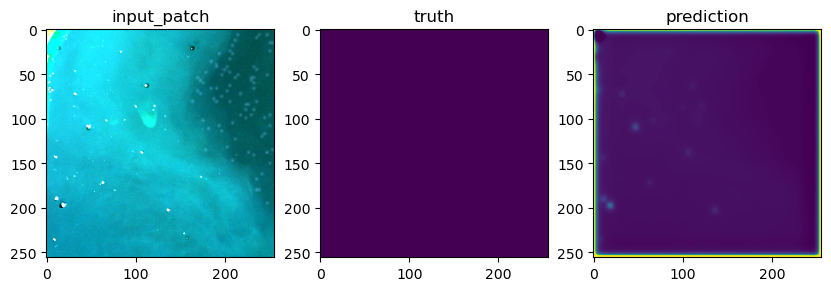

Ep11: tra-> Loss:0.123,Oa:0.93,Miou:0.88, val-> Loss:0.17,Oa:0.96,Miou:0.87,time:97s
Ep12: tra-> Loss:0.139,Oa:0.83,Miou:0.75, val-> Loss:0.28,Oa:0.79,Miou:0.63,time:97s
Ep13: tra-> Loss:0.166,Oa:0.86,Miou:0.77, val-> Loss:0.09,Oa:0.97,Miou:0.94,time:98s
Ep14: tra-> Loss:0.177,Oa:0.86,Miou:0.79, val-> Loss:0.14,Oa:0.97,Miou:0.84,time:97s
Ep15: tra-> Loss:0.130,Oa:0.91,Miou:0.82, val-> Loss:0.11,Oa:0.96,Miou:0.87,time:97s
Ep16: tra-> Loss:0.149,Oa:0.83,Miou:0.73, val-> Loss:0.12,Oa:0.95,Miou:0.83,time:97s
Ep17: tra-> Loss:0.123,Oa:0.90,Miou:0.84, val-> Loss:0.11,Oa:0.97,Miou:0.90,time:97s
Ep18: tra-> Loss:0.124,Oa:0.94,Miou:0.86, val-> Loss:0.16,Oa:0.95,Miou:0.75,time:97s
Ep19: tra-> Loss:0.101,Oa:0.84,Miou:0.78, val-> Loss:0.13,Oa:0.95,Miou:0.87,time:98s
Ep20: tra-> Loss:0.130,Oa:0.93,Miou:0.85, val-> Loss:0.11,Oa:0.98,Miou:0.87,time:97s


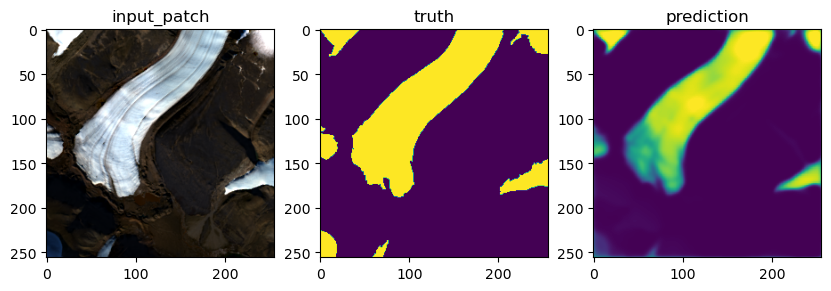

In [7]:
# device = torch.device('cpu') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loops(model=model, 
            loss_fn=loss_bce, 
            optimizer=optimizer,
            tra_loader=tra_loader, 
            val_loader=val_loader, 
            epoches=20,
            device=device)


In [8]:
# model saving
path_save = 'model/trained/unet_l5789_s2.pth'
torch.save(model.state_dict(), path_save)   # save weights of the trained model 
model.load_state_dict(torch.load(path_save))  # load the weights of the trained model


/tmp/ipykernel_3799980/3364168057.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_save))  # load the weights of the trained model


<All keys matched successfully>